# Decision tree classifier: diabetes prediction

Absolutely minimal MVP (minimum viable product) solution.

## 1. Data acquisition

### 1.1. Load

In [1]:
import pandas as pd

# Set random seed for notebook
random_seed=42

# Set train-test split fraction
testing_fraction=0.2

# Load the data from the URL
data_df=pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv")
data_df.drop_duplicates().reset_index(inplace=True, drop=True)

### 1.2. Train-test split

In [2]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing
training_df, testing_df=train_test_split(
    data_df,
    test_size=testing_fraction,
    random_state=random_seed
)

# Reset the indexes
training_df.reset_index(inplace=True, drop=True)
testing_df.reset_index(inplace=True, drop=True)

## 3. Baseline decision tree classifier

In [3]:
# Get features and labels
training_labels=training_df['Outcome']
training_features=training_df.drop('Outcome', axis=1)

In [4]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight='balanced'),
    training_features,
    training_labels,
    cv=StratifiedKFold(7),
    n_jobs=-1,
    scoring='accuracy'
)

print(f'Cross-validation accuracy: {(scores.mean() * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 71.2 +/- 3.5%


## 2. EDA

In [5]:
# Inspect the data types
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               614 non-null    int64  
 1   Glucose                   614 non-null    int64  
 2   BloodPressure             614 non-null    int64  
 3   SkinThickness             614 non-null    int64  
 4   Insulin                   614 non-null    int64  
 5   BMI                       614 non-null    float64
 6   DiabetesPedigreeFunction  614 non-null    float64
 7   Age                       614 non-null    int64  
 8   Outcome                   614 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 43.3 KB


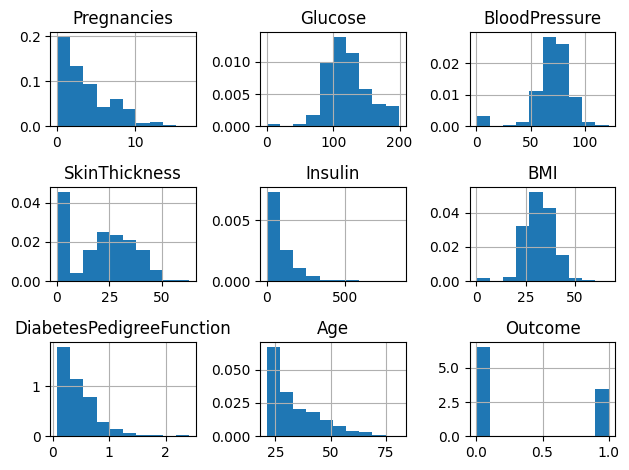

In [6]:
import matplotlib.pyplot as plt

training_df.hist(density=True, layout=(3,3))
plt.tight_layout()
plt.show()

In [7]:
training_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,3.742671,120.855049,69.415309,20.399023,81.438111,31.983388,0.469168,32.907166,0.346906
std,3.313264,32.035057,18.512599,15.433974,116.234835,7.740625,0.336847,11.503437,0.476373
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,100.000000,64.000000,0.000000,0.000000,27.100000,0.241500,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,42.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,139.000000,80.000000,32.000000,129.750000,36.375000,0.613750,40.000000,1.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


First weird thing... we have at least one record where everything except DPF and age is zero - I'm pretty sure that someone didn't have 0 blood pressure! That's probably missing data. Just how much is there?

In [8]:
dead_people=len(training_df[training_df['BloodPressure'] == 0])
print(f'Have {dead_people} people with a blood pressure of 0')

Have 24 people with a blood pressure of 0


Ok, if we were to remove rows that contain zero in one of 'Glucose','BloodPressure','SkinThickness','Insulin','BMI', how much data would we have left?

In [9]:
import numpy as np

# Features to look for zeros in
missing_data_features=['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

# Remove rows that have at least one zeros, using a copy, in case we decide it's a bad idea
filtered_training_df=training_df.copy()
filtered_training_df[missing_data_features]=filtered_training_df[missing_data_features].replace({0:np.nan})
filtered_training_df.dropna(inplace=True)

filtered_training_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000
mean,3.285714,123.046584,70.636646,28.751553,154.940994,32.959938,0.507724,30.534161,0.319876
std,3.155233,30.363750,12.788537,10.459256,119.910375,7.151758,0.344815,9.833841,0.467154
min,0.000000,56.000000,24.000000,10.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,100.000000,62.000000,20.000000,78.250000,27.800000,0.267250,23.000000,0.000000
50%,2.000000,119.500000,70.000000,28.500000,121.000000,32.900000,0.441000,27.000000,0.000000
75%,5.000000,142.000000,80.000000,36.000000,183.750000,36.875000,0.652750,35.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Wow, ok - so that's almost half of our data! We can't just throw all of those examples away. Let's try a simple imputation for each feature.

In [10]:
imputed_training_features=training_features.copy()

for target_feature in missing_data_features:

    target_feature_min=imputed_training_features[imputed_training_features[target_feature] != 0][target_feature].min()
    imputed_training_features[target_feature]=imputed_training_features[target_feature].replace({0:target_feature_min})

    print(f'{target_feature} imputed value: {target_feature_min:.1f}')

imputed_training_features.describe()

Glucose imputed value: 44.0
BloodPressure imputed value: 24.0
SkinThickness imputed value: 8.0
Insulin imputed value: 14.0
BMI imputed value: 18.2


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,3.742671,121.213355,70.353420,22.692182,88.050489,32.190879,0.469168,32.907166
std,3.313264,30.905662,15.294942,12.554145,111.717100,7.096649,0.336847,11.503437
min,0.000000,44.000000,24.000000,8.000000,14.000000,18.200000,0.078000,21.000000
25%,1.000000,100.000000,64.000000,8.000000,14.000000,27.100000,0.241500,24.000000
50%,3.000000,117.000000,72.000000,23.000000,42.500000,32.000000,0.372500,29.000000
75%,6.000000,139.000000,80.000000,32.000000,129.750000,36.375000,0.613750,40.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000


Try the cross-validation again and see how we did.

In [11]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight='balanced'),
    imputed_training_features,
    training_labels,
    cv=StratifiedKFold(7),
    n_jobs=-1,
    scoring='accuracy'
)

print(f'Cross-validation accuracy: {(scores.mean() * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 71.0 +/- 3.5%


In [12]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import QuantileTransformer

# Save the feature names for later - the imputer will return a numpy array
# and we might like to get out Pandas dataframe back
feature_names=training_features.columns

# Make a copy of the training features dataframe, in case we decide that this
# is a bad idea
imputed_training_features=training_features.copy()
imputed_training_features[missing_data_features]=imputed_training_features[missing_data_features].replace({0:np.nan})

# Quantile transform our target features - this is for the imputer, not the decision tree
qt=QuantileTransformer(n_quantiles=10, random_state=0)
qt.fit(imputed_training_features[missing_data_features])
imputed_training_features[missing_data_features]=qt.transform(imputed_training_features[missing_data_features])

# Run the imputation
imp=IterativeImputer(max_iter=100, verbose=True, tol=1e-6)
imp.fit(imputed_training_features)
imputed_training_features=imp.transform(imputed_training_features)

# Convert back to pandas
imputed_training_features=pd.DataFrame(data=imputed_training_features, columns=feature_names)

[IterativeImputer] Completing matrix with shape (614, 8)
[IterativeImputer] Change: 0.8850531789878213, scaled tolerance: 8.099999999999999e-05 
[IterativeImputer] Change: 0.08509623059966442, scaled tolerance: 8.099999999999999e-05 
[IterativeImputer] Change: 0.04089592715771981, scaled tolerance: 8.099999999999999e-05 
[IterativeImputer] Change: 0.023640014648550006, scaled tolerance: 8.099999999999999e-05 
[IterativeImputer] Change: 0.013677322837206518, scaled tolerance: 8.099999999999999e-05 
[IterativeImputer] Change: 0.007913158618769095, scaled tolerance: 8.099999999999999e-05 
[IterativeImputer] Change: 0.00457794178757398, scaled tolerance: 8.099999999999999e-05 
[IterativeImputer] Change: 0.0026482928595220057, scaled tolerance: 8.099999999999999e-05 
[IterativeImputer] Change: 0.001531939127586035, scaled tolerance: 8.099999999999999e-05 
[IterativeImputer] Change: 0.000886135933858806, scaled tolerance: 8.099999999999999e-05 
[IterativeImputer] Change: 0.000512560844257964

In [13]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight='balanced'),
    imputed_training_features,
    training_labels,
    cv=StratifiedKFold(7),
    n_jobs=-1,
    scoring='accuracy'
)

print(f'Cross-validation accuracy: {(scores.mean() * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 71.0 +/- 2.9%


## 4. Evaluation

In [14]:
model=DecisionTreeClassifier(random_state=random_seed)
fit_result=model.fit(imputed_training_features, training_labels)

In [15]:
# Get features and labels
testing_labels=testing_df['Outcome']
testing_features=testing_df.drop('Outcome', axis=1)

imputed_testing_features=testing_features.copy()
imputed_testing_features[missing_data_features]=imputed_testing_features[missing_data_features].replace({0:np.nan})

imputed_testing_features[missing_data_features]=qt.transform(imputed_testing_features[missing_data_features])
imputed_testing_features=imp.transform(imputed_testing_features)

# Convert back to pandas
imputed_testing_features=pd.DataFrame(data=imputed_testing_features, columns=feature_names)
imputed_testing_features.describe()

[IterativeImputer] Completing matrix with shape (154, 8)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,4.253247,0.487786,0.496649,0.532094,0.492617,0.525223,0.482675,34.571429
std,3.567394,0.304317,0.268550,0.250986,0.250296,0.270809,0.309155,12.685155
min,0.000000,0.045455,0.078431,0.000000,0.002778,0.003704,0.102000,21.000000
25%,1.250000,0.191919,0.229167,0.361321,0.284200,0.310714,0.247250,24.000000
50%,3.000000,0.416667,0.500000,0.521726,0.493333,0.552778,0.372500,29.500000
75%,7.000000,0.793322,0.666667,0.722222,0.709655,0.763211,0.679250,42.000000
max,13.000000,0.993569,0.974522,1.000000,0.947750,0.941127,1.390000,67.000000


In [16]:
# Make predictions from test set features
predicted_labels=model.predict(imputed_testing_features)

# Score predictions from accuracy
percent_accuracy=accuracy_score(testing_labels, predicted_labels) * 100
print(f'Model is {percent_accuracy:.1f}% accurate on the test data')

Model is 64.9% accurate on the test data


## 5. Optimization

In [17]:
from sklearn.feature_selection import RFECV

min_features_to_select=1
clf=DecisionTreeClassifier(random_state=random_seed)

rfecv = RFECV(
    estimator=model,
    step=1,
    cv=StratifiedKFold(7),
    scoring='accuracy',
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)
rfecv.fit(imputed_training_features, training_labels)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 4


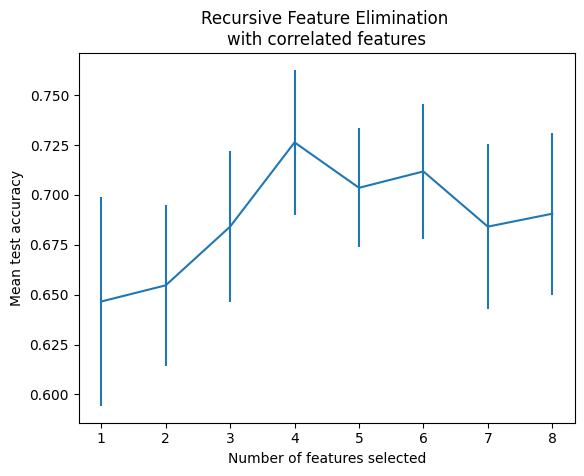

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

cv_results = pd.DataFrame(rfecv.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [19]:
imputed_training_features=imputed_training_features.to_numpy()
selected_imputed_training_features=imputed_training_features[:,rfecv.get_support()]

selected_feature_names=[b for a, b in zip(rfecv.get_support(), feature_names) if a]
selected_imputed_training_features=pd.DataFrame(data=selected_imputed_training_features, columns=selected_feature_names)
selected_imputed_training_features.head()


,Glucose,Insulin,BMI,Age
0,0.101010,0.232703,0.406815,21.0
1,0.416667,0.390575,0.300000,50.0
2,0.746032,0.269750,0.323810,22.0
3,0.871042,0.725229,0.068519,65.0
4,0.706349,0.906849,0.911478,46.0


In [20]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight='balanced'),
    selected_imputed_training_features,
    training_labels,
    cv=StratifiedKFold(7),
    n_jobs=-1,
    scoring='accuracy'
)

print(f'Cross-validation accuracy: {(scores.mean() * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 73.0 +/- 3.1%


In [ ]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

model=DecisionTreeClassifier(random_state=random_seed)

distributions={
    # 'criterion': ['gini', 'entropy'],
    # 'splitter': ['best', 'random'],
    'max_depth': list(range(1, 10)),
    'min_samples_split': list(range(10, 50)),
    'min_samples_leaf': list(range(10, 50)),
    # 'min_weight_fraction_leaf': uniform(loc=0, scale=0.5),
    # 'max_features': uniform(loc=0, scale=1),
    # 'min_impurity_decrease': uniform(loc=0, scale=1),
    # 'class_weight': [None, 'balanced']
}

grid=RandomizedSearchCV(
    model,
    distributions,
    scoring='accuracy',
    n_jobs=-1,
    cv=StratifiedKFold(7),
    n_iter=100,
    random_state=random_seed
)

results=grid.fit(selected_imputed_training_features, training_labels)
print(f'Best hyperparameters: {results.best_params_}')

Best hyperparameters: {'min_samples_split': 24, 'min_samples_leaf': 42, 'max_depth': 9}


/mnt/arkk/4geeks_repos/gperdrizet-decision-tree-project/.venv/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [27]:
model=DecisionTreeClassifier(
    # class_weight=results.best_params_['class_weight'],
    # criterion=results.best_params_['criterion'],
    max_depth=results.best_params_['max_depth'],
    # max_features=results.best_params_['max_features'],
    # min_impurity_decrease=results.best_params_['min_impurity_decrease'],
    min_samples_leaf=results.best_params_['min_samples_leaf'],
    min_samples_split=results.best_params_['min_samples_split'],
    # min_weight_fraction_leaf=results.best_params_['min_weight_fraction_leaf'],
    # splitter=results.best_params_['splitter'],
    random_state=random_seed
)

fit_result=model.fit(selected_imputed_training_features, training_labels)

In [28]:
# Get features and labels
testing_labels=testing_df['Outcome']
testing_features=testing_df.drop('Outcome', axis=1)

imputed_testing_features=testing_features.copy()
imputed_testing_features[missing_data_features]=imputed_testing_features[missing_data_features].replace({0:np.nan})

imputed_testing_features[missing_data_features]=qt.transform(imputed_testing_features[missing_data_features])
imputed_testing_features=imp.transform(imputed_testing_features)

# Convert back to pandas
imputed_testing_features=pd.DataFrame(data=imputed_testing_features, columns=feature_names)
imputed_testing_features.describe()

[IterativeImputer] Completing matrix with shape (154, 8)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,4.253247,0.487786,0.496649,0.532094,0.492617,0.525223,0.482675,34.571429
std,3.567394,0.304317,0.268550,0.250986,0.250296,0.270809,0.309155,12.685155
min,0.000000,0.045455,0.078431,0.000000,0.002778,0.003704,0.102000,21.000000
25%,1.250000,0.191919,0.229167,0.361321,0.284200,0.310714,0.247250,24.000000
50%,3.000000,0.416667,0.500000,0.521726,0.493333,0.552778,0.372500,29.500000
75%,7.000000,0.793322,0.666667,0.722222,0.709655,0.763211,0.679250,42.000000
max,13.000000,0.993569,0.974522,1.000000,0.947750,0.941127,1.390000,67.000000


In [29]:
imputed_testing_features=imputed_testing_features.to_numpy()
selected_imputed_testing_features=imputed_testing_features[:,rfecv.get_support()]

selected_feature_names=[b for a, b in zip(rfecv.get_support(), feature_names) if a]
selected_imputed_testing_features=pd.DataFrame(data=selected_imputed_testing_features, columns=selected_feature_names)
selected_imputed_testing_features.head()

,Glucose,Insulin,BMI,Age
0,0.212121,0.764706,0.627451,43.0
1,0.416667,0.457972,0.711382,21.0
2,0.361111,0.394951,0.438889,21.0
3,0.347222,0.279580,0.129890,34.0
4,0.722222,0.566059,0.388889,50.0


In [31]:
# Make predictions from test set features
predicted_labels=model.predict(selected_imputed_testing_features)

# Score predictions from accuracy
percent_accuracy=accuracy_score(testing_labels, predicted_labels) * 100
print(f'Model is {percent_accuracy:.1f}% accurate on the test data')

Model is 73.4% accurate on the test data
